<a href="https://colab.research.google.com/github/elsa9421/Interactive-IPython-Demos/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN For Image Classification

# Import
For the CIFAR10 datset and build the Convolutional Neural Network

In [ ]:

#imports for the dataset and building our neural network

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time


if torch.cuda.is_available:
  device='cuda'
  print('PyTorch can use GPUs!')
else:
  device='cpu'
  print('PyTorch cannot use GPUs.')

PyTorch can use GPUs!


#  Load the CIFAR10 training and test datasets using torchvision

About CIFAR10 datset : https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

 CIFAR-10 dataset details:
* Total Number of images=60000 (each being 32x32 colour image)
* Number of Classes :10
* Number of images per class=6000
* Number of Training Images: 50000
* Number of Test Images: 10000



# Normalising the loaded dataset

Torchvision uses Pillow (PIL) as the default backend for loading the image. The output of torchvision datasets are therefore PILImage images. We transform them to Tensors of normalized range [-1, 1] by using torchvision's transforms module.
The transforms module is commonly used for preprocessing functionalities.  

<br>`transforms.Compose`: groups transform objects together to make a single pipeline.
<br>`transforms.ToTensor`: converts the three-channeled input RGB image to a three-dimensional tensor with size channel x width × height as 'channel first' order is expected by vision networks in PyTorch.<br> ToTensor also converts the pixel values from a range of 0 to 255 for each channel to a range of 0.0 to 1.0.

<br>`transforms.Normalize`: does the following for each channel: image = (image - mean) / std. <br>The parameters mean, std are passed as 0.5, 0.5 in the following case. This will normalize the image in the range [-1,1].<br> For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to 1

In [ ]:
# loading the dataset 

transform = transforms.Compose(
                                [transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                               )



cifar10_trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=4,shuffle=True, num_workers=2)

cifar10_testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=4,shuffle=False, num_workers=2)

classes = {0:'plane', 1:'car', 2:'bird', 3: 'cat',4:'deer', 5:'dog', 6: 'frog', 7:'horse',8: 'ship',9: 'truck'}
num_classes=len(classes)

# print(len(trainloader))  #12500 , as 50000=4x12500
# print(len(testloader))   #2500  , as 10000=4x2500

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])


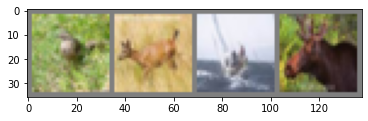


      bird       deer       ship       deer


In [ ]:
#Display 4 random images
def imshow(img):

  img = img / 2 + 0.5     # unnormalize
  img = img.numpy().transpose(1, 2, 0)  #convert to numpy array ad then transpose to get width x height x channel

 
  plt.imshow(img)
  plt.show()

train_loader_iter = iter(trainloader)
img,labels=train_loader_iter.next()
print(type(img))
print(img.size())

# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(' '.join('%10s' % classes[label.item()] for label in labels))

# CNN
The CNN is defined with the following layer sequence

<br>Sequential(<br>
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))<br>
  (1): ReLU()<br>
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1,    ceil_mode=False)<br>
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))<br>
  (4): ReLU()<br>
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)<br>
  (6): Linear(in_features=400, out_features=120, bias=True)<br>
  (7): ReLU()<br>
  (8): Linear(in_features=120, out_features=84, bias=True)<br>
  (9): ReLU()<br>
  (10): Linear(in_features=84, out_features=10, bias=True)<br>
)

In [ ]:

class ConvNet(torch.nn.Module):
    def __init__(self,num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)    #torch.Size([6, 3, 5, 5])
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)   #torch.Size([16, 6, 5, 5])
        self.fc1 = torch.nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        #print("1:",x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print("3:",x.shape)
        x = x.view(-1, 16 * 5 * 5)    #(num_images,400)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# (3x32x32) -> conv1 -> (32-5+1) -> (6x28x28)
# (6x28x28) ->maxpool1 -> (28/2) -> (6x14x14)
# (6x14x14) ->conv2 -> (14-5+1) -> (16x10x10)
# (16x10x10) -> maxpool2 -> (10/2) -> (16x5x5)
# (16x5x5) = 400 -> Linear -> 120
#  120   -> Linear-> 84
#   84 -> Linear -> output_dim =10

net = ConvNet(num_classes).to(device)
net






ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#Hyperparamters

In [ ]:


# Hyperparameters
num_epochs = 2
batch_size = 4
learning_rate = 0.001

# Using Classification Cross-Entropy loss and Adam optimizer.

#Define a Loss function
criterion = torch.nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)   #SGD optimizer :stochastic Gradient descent with momentum
# Using Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)



# Train the Network

In [ ]:

# Train the network
torch.cuda.synchronize()
t0=time.time()
N=len(trainloader)
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
 
        #inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # Forward pass: compute predicted output by passing inputs to net()
        outputs = net(inputs)   #inputs:torch.Size([4, 3, 32, 32]) outputs:torch.Size([4, 10])
      
        # Compute loss.
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        
        #To print statistics
        running_loss += loss.item()   
        

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[Epoch: {:1d}/{:1d} Iteration:{:1d}/{:1d}] loss: {:.3f}'
            .format(epoch + 1,num_epochs, i + 1,N, running_loss / 2000))
            running_loss = 0.0

t1=time.time()
print(t1-t0)
print('Finished Training')

[Epoch: 1/2 Iteration:2000/12500] loss: 1.861
[Epoch: 1/2 Iteration:4000/12500] loss: 1.616
[Epoch: 1/2 Iteration:6000/12500] loss: 1.538
[Epoch: 1/2 Iteration:8000/12500] loss: 1.454
[Epoch: 1/2 Iteration:10000/12500] loss: 1.433
[Epoch: 1/2 Iteration:12000/12500] loss: 1.390
[Epoch: 2/2 Iteration:2000/12500] loss: 1.335
[Epoch: 2/2 Iteration:4000/12500] loss: 1.330
[Epoch: 2/2 Iteration:6000/12500] loss: 1.299
[Epoch: 2/2 Iteration:8000/12500] loss: 1.285
[Epoch: 2/2 Iteration:10000/12500] loss: 1.291
[Epoch: 2/2 Iteration:12000/12500] loss: 1.260
194.86797547340393
Finished Training


To save the trained model

In [ ]:


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


#Test the network

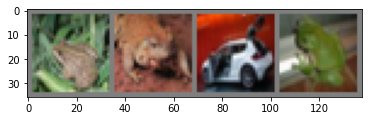

GroundTruth:   frog  frog   car  frog
Predicted:   frog  frog   car  frog


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[label.item()] for label in labels))
########################################################################
# testing

outputs_test = net(images.to(device))
_, predicted = torch.max(outputs_test, 1)  #returns a tuple (max_values,indices)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(4)))

########################################################################

# Accuracy

In [ ]:
#Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct / total))